# Nasdaq Exploration Analysis

Main questions of focus are:
- zmeny za deň/rok
- rolling average
- distribúcia dát
- korelácia s ostatnými fondami/akciam
- seasonal decompose
- outlieri
- clusteing akcii

pozri či ti je na niečo adj

In [58]:
import sklearn.cluster
import sklearn.preprocessing
import sklearn.pipeline

import seaborn
import pandas
import numpy
import os

seaborn.set_theme()
seaborn.set(rc={'figure.figsize':(17, 10)})

### Preparing the data

At first it would be usefull to concatenate all the stocks into one dataframe and sort them by date.

In [3]:
dir_list = os.listdir("/home/benb/Documents/cuni/4sem/data-mining/nasdaq/stocks")
curr_path = os.getcwd()
nasdaq_symbols = []

stocks = {}
for file in dir_list[:500]:
    symbol = file.strip(".csv")
    nasdaq_symbols.append(symbol)
    stocks[symbol] = pandas.read_csv(f"stocks/{file}")
    stocks[symbol]["Symbol"] = symbol
    
    stocks[symbol]['TimeStamp'] = pandas.to_datetime(stocks[symbol]['Date'],format= '%Y-%m-%d')
    stocks[symbol].drop(columns=['Date'],inplace=True)

nasdaq = pandas.DataFrame(columns=['Symbol', 'TimeStamp', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'])
nasdaq = pandas.concat(list(stocks.values()))
nasdaq = nasdaq.sort_values('TimeStamp')
nasdaq.info(), nasdaq.head(n=20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2062858 entries, 0 to 79
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Open       float64       
 1   High       float64       
 2   Low        float64       
 3   Close      float64       
 4   Adj Close  float64       
 5   Volume     float64       
 6   Symbol     object        
 7   TimeStamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 141.6+ MB


(None,
         Open      High       Low     Close  Adj Close    Volume Symbol  \
 0   1.234375  1.257812  1.234375  1.257812   0.013604  243200.0   UTX#   
 1   1.257812  1.265625  1.250000  1.253906   0.013562  172800.0   UTX#   
 2   1.253906  1.253906  1.242188  1.250000   0.013519  281600.0   UTX#   
 3   1.250000  1.250000  1.226562  1.234375   0.013350  124800.0   UTX#   
 4   1.234375  1.246094  1.226562  1.226562   0.013266  102400.0   UTX#   
 5   1.226562  1.250000  1.226562  1.234375   0.013350  134400.0   UTX#   
 6   1.234375  1.246094  1.234375  1.242188   0.013435   80000.0   UTX#   
 7   1.234375  1.234375  1.199219  1.199219   0.012970  608000.0   UTX#   
 8   1.195312  1.195312  1.113281  1.121094   0.012125  745600.0   UTX#   
 9   1.113281  1.113281  1.062500  1.078125   0.011660  694400.0   UTX#   
 10  1.070312  1.070312  1.046875  1.066406   0.011534  700800.0   UTX#   
 11  1.062500  1.062500  1.031250  1.031250   0.011153  473600.0   UTX#   
 12  1.031250  1.0

### Trading Period

In [63]:
period_start = pandas.to_datetime("2018-01-01" ,format= '%Y-%m-%d')
period_end = pandas.to_datetime("2019-01-01" ,format= '%Y-%m-%d')

valid = {}  # stocks which were active during selected period
nof_records = {}  # frequency of the number of records

for sym in nasdaq_symbols:
    start_date = stocks[sym]['TimeStamp'].min()
    end_date = stocks[sym]['TimeStamp'].max()

    if start_date <= period_start and end_date >= period_end:
        trimmed = stocks[sym][(stocks[sym]['TimeStamp'] >= period_start) & (stocks[sym]['TimeStamp'] <= period_end)]
        valid[sym] = ((trimmed['Close'] - trimmed['Open']) / trimmed['Open']).to_list()
        recs = len(valid[sym])

        if recs in nof_records: nof_records[recs] += 1
        else: nof_records[recs] = 0

# remove stocks which have missing data
desired_nof_records = max(nof_records, key=nof_records.get)
valid = {k:v for k, v in valid.items() if len(v) == desired_nof_records}

movements = pandas.DataFrame.from_dict(valid)
movements.isnull().values.any()
movements

/home/benb/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/benb/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ATSG,ZEUS,BNED,DDS,NSEC,WATT,JHX,SNFCA,SRG,IGI,...,MLVF,WMT,PHIO,ALL,MS,CVLY,ENDP,STNG,BBW,SAVA
0,-4.529153,-3.774139,-4.331932,-5.710754,-4.682134,-3.818629,-4.909262,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-3.258096,-3.784189,-4.527205,-4.617594
1,-3.720821,-3.549978,NaN,NaN,-inf,-3.289201,-4.776308,-4.624972,-3.817961,-4.942536,...,NaN,-5.104432,NaN,-7.437512,-7.463468,-5.132490,-2.754742,NaN,-4.132499,-5.320569
2,-3.988575,NaN,NaN,NaN,NaN,NaN,-5.184585,NaN,NaN,NaN,...,-5.091706,-inf,NaN,NaN,-5.075168,NaN,NaN,-4.669711,NaN,-2.717878
3,-5.741802,NaN,NaN,-3.838141,-2.711220,-3.719654,-5.182903,-4.828302,-6.687048,-4.818497,...,-4.404681,-5.314918,NaN,-5.079522,NaN,-7.237722,NaN,NaN,NaN,NaN
4,NaN,-3.666258,NaN,-4.019776,-4.256205,NaN,-5.541268,NaN,NaN,NaN,...,NaN,-4.300182,NaN,NaN,NaN,-5.036230,NaN,NaN,-3.817713,-4.477343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,NaN,NaN,NaN,NaN,-inf,NaN,-4.519813,-3.799230,-5.205944,-4.996642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.528800,NaN,NaN
247,-2.865426,NaN,NaN,-2.889664,-inf,NaN,-3.212024,NaN,-2.654522,-6.799128,...,-4.106636,-3.075427,-2.708050,-3.172268,-2.915359,-4.842329,-3.613618,-3.096709,-5.280663,-2.944438
248,-3.648059,-3.519884,-3.132774,-4.336696,-inf,-1.786797,-2.622219,NaN,-4.705018,-4.363931,...,-3.788408,-3.887264,-inf,-3.691390,-3.484624,-inf,NaN,-3.812204,-3.671223,NaN
249,-5.383114,-3.819485,-3.550138,NaN,-inf,NaN,-5.887038,NaN,NaN,NaN,...,-3.787283,-7.336001,NaN,NaN,NaN,NaN,-4.029463,NaN,NaN,NaN


In [62]:
n_clusters = 20
norm = sklearn.preprocessing.Normalizer()
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, max_iter=10_000)
pipeline = sklearn.pipeline.make_pipeline(kmeans)
pipeline.fit(movements.T)# Prediction
labels = pipeline.predict(movements.T)

sym_labels = pandas.DataFrame({'lab':labels, 'sym': movements.columns})

for i in range(n_clusters):
    print(f"index: {i}, size of cluster: {len(sym_labels[sym_labels['lab'] == i])}")

index: 0, size of cluster: 26
index: 1, size of cluster: 1
index: 2, size of cluster: 1
index: 3, size of cluster: 1
index: 4, size of cluster: 1
index: 5, size of cluster: 1
index: 6, size of cluster: 163
index: 7, size of cluster: 1
index: 8, size of cluster: 1
index: 9, size of cluster: 1
index: 10, size of cluster: 1
index: 11, size of cluster: 1
index: 12, size of cluster: 2
index: 13, size of cluster: 1
index: 14, size of cluster: 1
index: 15, size of cluster: 198
index: 16, size of cluster: 1
index: 17, size of cluster: 1
index: 18, size of cluster: 1
index: 19, size of cluster: 1


14


[(-0.1, 0.1)]

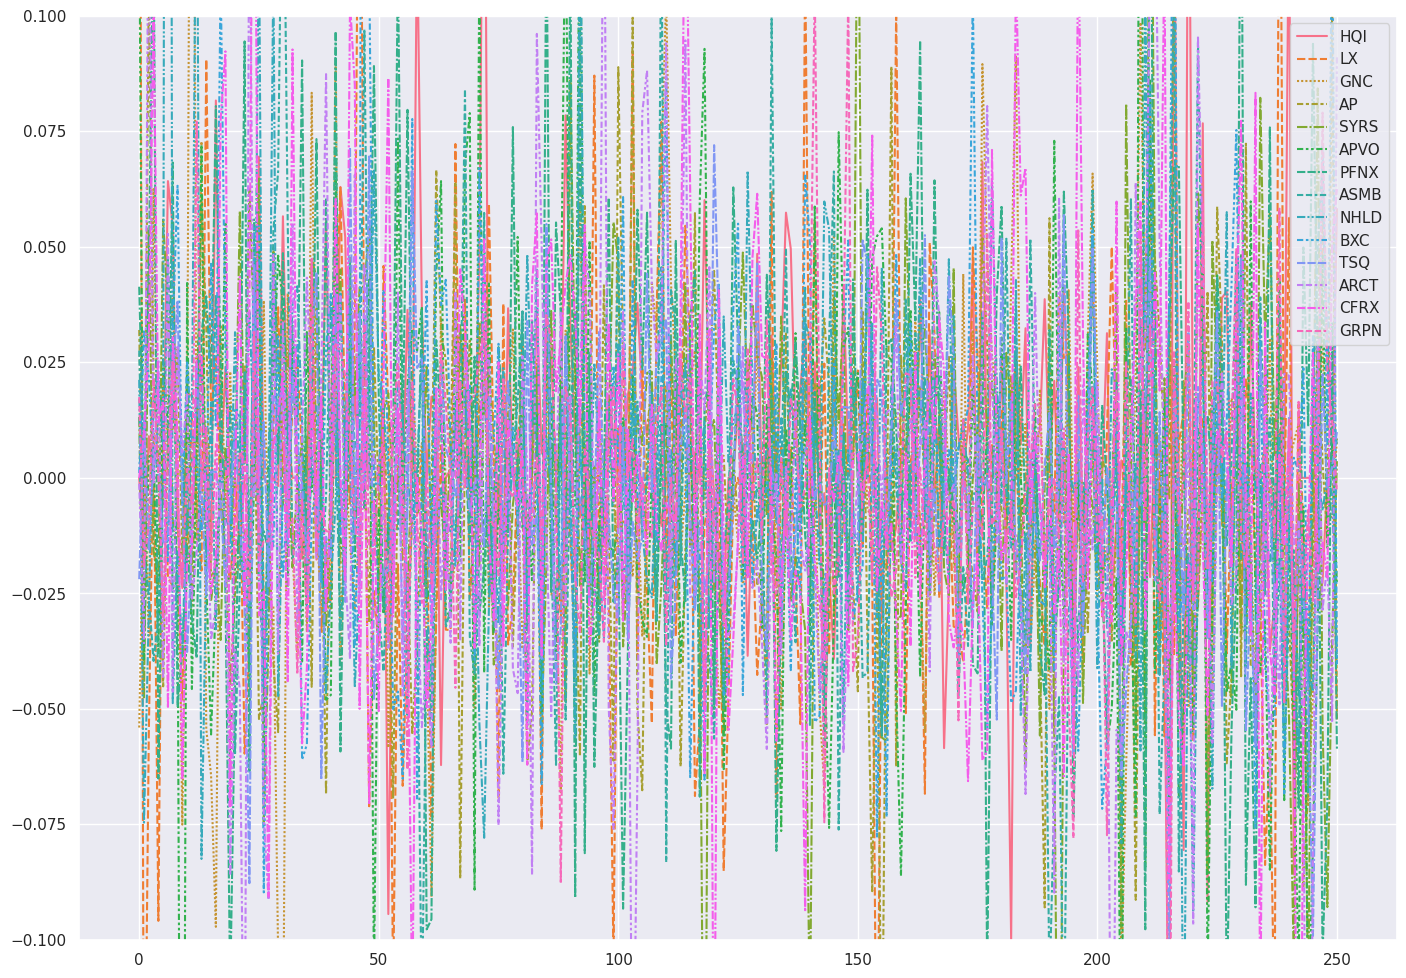

In [57]:

cluster = sym_labels[sym_labels['lab'] == 10]['sym'].to_list()
print(len(cluster))
movements[cluster]
line_plot = seaborn.lineplot(data=movements[cluster], legend=True)
line_plot.set(ylim=(-0.1, 0.1))

signum
matica korelacii